# Entrega 3

En esta última entrega del miniproyecto utilizaremos el método de segmentación mediante umbralización y realizaremos una experimentación detallada para seleccionar el método de detección final. Para esto, realizaremos un preprocesamiento de los canales de las imágenes, basándonos en lo explorado durante la primera entrega del miniproyecto y utilizando transformaciones de intensidades. Una vez implementado el preprocesamiento, aplicaremos la umbralización utilizando cuatro estrategias diferentes. Además, usando las combinaciones de métodos de umbralización y preprocesamiento que consideren de mejor calidad cualitativamente, procesaremos la base de datos de validación para realizar una evaluación cualitativa. Por último, realizarán la evaluación de su mejor método en la base de datos de prueba para obtener el desempeño de nuestra metodología.

## Parte 1: Umbralización
Al igual que en la primera entrega, umbralizaremos nuestras imágenes para obtener máscaras binarias. Sin embargo, el método de obtención de los umbrales será lo que varíe. Como bien sabemos, existen varios métodos de umbralización, entre los cuales se encuentran Otsu, umbralización por percentiles y umbrales arbitrarios.

En este caso solo vamos a implementar funciones para umbralización por percentiles y umbralización mediante umbral arbitrario.

In [4]:
# Importación de las librerías necesarias.
# Si necesita usar más librerías agreguelas en este espacio para mantener su código organizado.
import os
import glob 
import numpy as np
import json

import cv2
from skimage import io, color
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
import requests
from PIL import Image
from skimage.exposure import match_histograms

from scipy.optimize import linear_sum_assignment

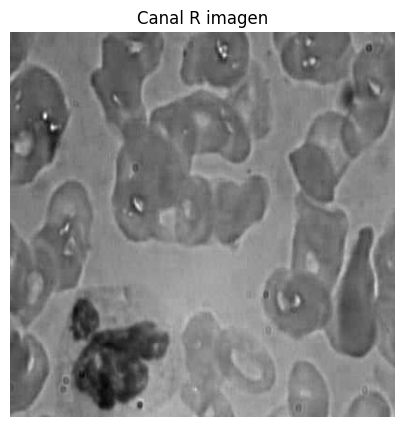

In [5]:
# compruebe que la imagen sea BloodImage_00001
# # Variable que contendrá la imagen de un unico canal, use la primera imagen de la base de datos de train y el canal R
img_path = glob.glob(os.path.join('data_mp1/BCCD/train', "BloodImage_00001_jpg*"))[0]
bw_img = io.imread(img_path)[:,:,0]

#C:\Users\User\Downloads\LAB_RECON\Mini1_e3\data_mp1\BCCD\train\BloodImage_00001_jpg.rf.ee79407f4ce4abd4fc56f42c176d324b.jpg

plt.figure(figsize=(5,5))
plt.imshow(bw_img, cmap='gray')
plt.title("Canal R imagen")
plt.axis("off")
plt.show()

### Parte 1.1: Percentiles
Primero implementaremos la umbralización mediante percentiles para eso puede utilizar la función que creó en la entrega pasada.

In [6]:
def umbralizacion_percentile(im,percentile):
    """ Esta función umbraliza una imagen en escala de grises con un umbral por percentil.

    Args:
        im (numpy.ndarray): Imagen a umbralizar.
        percentile (float): percentile a utilizar para realizar la umbralización.

    Returns:
        (numpy.ndarray): Imagen umbralizada.
    
    """
    assert len(im.shape) < 3, "La imagen debe ser en escala de grises"

    umbral = np.percentile(im, percentile)
    percentilebin_img = (im < umbral)#imagen umbralizada
    
    return percentilebin_img

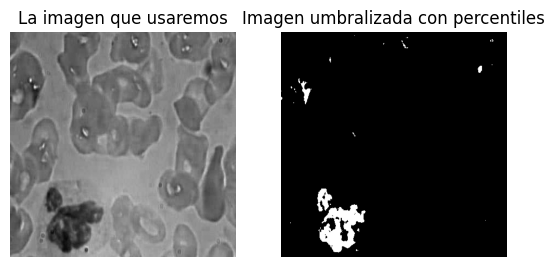

In [7]:
percentilebin_img=umbralizacion_percentile(bw_img,3)

fig,ax=plt.subplots(1, 2)
ax[0].imshow(bw_img,cmap='gray')
ax[0].set_title('La imagen que usaremos')
ax[0].axis('off')
ax[1].imshow(percentilebin_img,cmap='gray')
ax[1].set_title('Imagen umbralizada con percentiles')
ax[1].axis('off')
plt.show()

assert np.sum(percentilebin_img)<416*416/2, 'Usted umbralizó la imagen al reves'
assert np.isclose(np.sum(percentilebin_img),4933) or np.isclose(np.sum(percentilebin_img),4922), 'El umbral del percentile es erroneo'

### Parte 1.2: Umbrales arbitrarios
Por último, los umbrales pueden ser seleccionados de forma arbitraria utilizando la información disponible. Aquí, podremos apoyarnos en gran medida en la información proporcionada por el histograma de intensidades de la imagen para determinar el umbral que vamos a utilizar, además de la condición (mayor o menor que). Cree una función que reciba como parámetro una imagen y el umbral a utilizar, y devuelva una imagen umbralizada.

In [8]:
def umbralizacion_arbitrario(im,umbral):
    """ Esta función umbraliza una imagen en escala de grises con un umbral arbitrario.

    Args:
        im (numpy.ndarray): Imagen a umbralizar.
        umbral (int): umbral a utilizar

    Returns:
        (numpy.ndarray): Imagen umbralizada.
    
    """
    arbitrarybin_img = (im < umbral) #imagen umbralizada

    return arbitrarybin_img

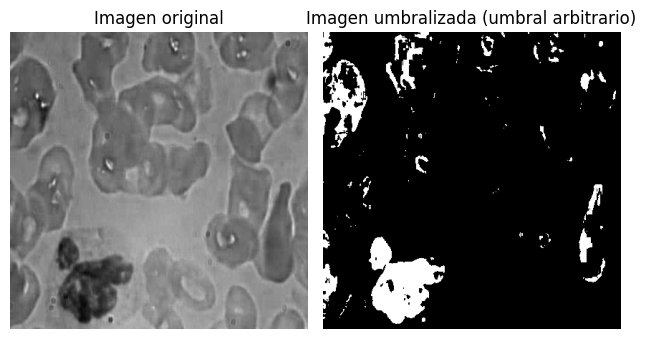

In [9]:
arbitrarybin_img=umbralizacion_arbitrario(bw_img,170)

fig,ax=plt.subplots(1,2)
ax[0].imshow(bw_img,cmap='gray')
ax[0].set_title('Imagen original')
ax[0].axis('off')
ax[1].imshow(arbitrarybin_img,cmap='gray')
ax[1].set_title('Imagen umbralizada (umbral arbitrario)')
ax[1].axis('off')
plt.tight_layout()
plt.show()

assert np.sum(arbitrarybin_img)<416*416/2, 'Usted umbralizó la imagen al reves'
assert np.isclose(np.sum(arbitrarybin_img),14952) or np.isclose(np.sum(arbitrarybin_img),14950), 'La umbralización fue erroneo'

## Parte 2: Predicciones
Ahora que tenemos un método de umbralización, vamos a generar un archivo .json de predicciones.

### Parte 2.1: Detección mediante componente conexo más grande
Lo primero que haremos será construir una función que realice el proceso que llevamos a cabo en la entrega anterior, donde, dada una máscara binaria, calculábamos las posiciones de la caja delimitadora.

En este caso, mejoraremos un poco nuestro método y añadiremos un umbral. Este umbral nos servirá para definir un tamaño mínimo para los glóbulos blancos. En la entrega anterior, nuestro método no consideraba que podría haber imágenes sin glóbulos blancos, por lo que, aunque no hubiera glóbulos blancos, el algoritmo intentaba detectarlos. En este caso, la adición de un umbral permite descartar componentes conexos más pequeños. Esta estrategia, aunque no es 100% efectiva, nos permite mejorar nuestro algoritmo.

In [10]:
def deteccion(mask,umbral):
    """ Esta función toma una imagen ya umbralizada y da como resultado la detección correspondiente.

    Args:
        mask (numpy.ndarray): Imagen donde se quiere detectar el glóbulo blanco.
        umbral (int): Área mínima que debe ocupar un glóbulo blanco para ser considerado como tal.
        Si el área del elemento conexo más grande no supera el umbral entonces retornaremos None en X, Y, W, H
        
    Returns:
        (int): coordenada X, (int): coordenada Y, (int): ancho de la caja (W), (int): alto de la caja (H)
    """
    img_bin = mask.astype(np.uint8)
    numero, labels, estad, centroides = cv2.connectedComponentsWithStats(img_bin)
    grande = 1 + np.argmax(estad[1:, cv2.CC_STAT_AREA])
    
    x = int(estad[grande, cv2.CC_STAT_LEFT]) # Coordenada x de la esquina superior izquierda
    y = int(estad[grande, cv2.CC_STAT_TOP]) # Coordenada y de la esquina superior izquierda
    w = int(estad[grande, cv2.CC_STAT_WIDTH]) # Ancho de la caja
    h = int(estad[grande, cv2.CC_STAT_HEIGHT]) # Altura de la caja
    
    return x, y, w, h

In [11]:
img_1 = io.imread(glob.glob(os.path.join('.','data_mp1','BCCD','train','*.jpg'))[0])[:,:,0]
percentilebin_img_1 = umbralizacion_percentile(img_1, 3)

assert deteccion(percentilebin_img, 1000) == (69, 319, 87, 89), 'La detección no fue correcta'

img_2 = io.imread(glob.glob(os.path.join('.','data_mp1','BCCD','train','*.jpg'))[17])[:,:,0]
percentilebin_img_2 = umbralizacion_percentile(img_2, 3)

assert deteccion(percentilebin_img_2, 1000) == (178, 11, 72, 118), 'La detección no fue correcta'

### Parte 2.2: Diccionario
Primero, generaremos un diccionario de predicción antes de crear un archivo .json. Cree una función que reciba como parámetro una imagen, un image_id, un método de segmentación y un dato adicional, y que devuelva un diccionario con las llaves image_id, category_id, bbox, y score. Use la función implementada en la parte anterior para obtener una bbox a partir de una imagen umbralizada (use un umbral de 1000). El score será el porcentaje de True dentro de la ventana de detección.

In [12]:
def diccionario_prediccion(image,image_id,segmentation_method,dato=None):
    """ Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna un diccionario con la predicción de la anotación.

    Args:
        image (numpy.ndarray):  Imagen de entrada de 1 canal.
        image_id (int): Identificador de la imagen.
        segmentation_method (str): Puede ser "percentile" o "arbitrario"
        dato (int or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parametró será el umbral o el percentil
        
    Returns:
        (dict): diccionario con llaves: images_id, category_id, bbox, score. 
        Correspondiente a la predicción del algoritmo sobre donde está el glóbulo blanco.
    """
    if segmentation_method == "percentile":
        mask = umbralizacion_percentile(image, dato)
    elif segmentation_method == "arbitrario":
        mask = umbralizacion_arbitrario(image, dato)

    if mask.sum() == 0:
        x, y, w, h = 0, 0, 0, 0
        score = 0
    else:
        x, y, w, h = deteccion(mask, 1000)
        ventana = mask[y:y+h, x:x+w]
        score = np.mean(ventana)
    
    dict_deteccion={
        'image_id': image_id,
        'category_id': 1,
        'bbox': [x, y, w, h],
        'score': score
    } #diccionario de prediccion
    
    return dict_deteccion

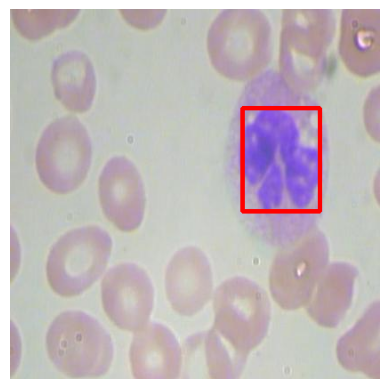

In [13]:
with open(os.path.join('data_mp1','BCCD','train','_annotations.coco.json'),'rb') as f:
    anots=json.load(f)

im_name=anots['images'][0]['file_name']
id_image=anots['images'][0]['id']
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
dict_predict=diccionario_prediccion(image[:,:,0],id_image,'percentile', 3)

assert type(dict_predict)==dict, 'El dict_predict deberia ser un diccionario'
assert 'image_id' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "image_id"'
assert 'category_id' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "category_id"'
assert 'bbox' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "bbox"'
assert 'score' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "score"'
assert dict_predict['score'] >=0 and dict_predict['score'] <=1, 'El score debe estar entre 0 y 1'
assert len(dict_predict['bbox'])==4, 'La bbox deberia tener 4 valores'

X,Y,W,H= dict_predict['bbox']
mask=umbralizacion_percentile(image[:,:,0], 3)
assert np.isclose(np.sum(mask[Y:Y+H,X:X+W])/(H*W),dict_predict['score']), 'El score está mal calculado, puede que ester usando las filas como columnas y viseversa'
assert np.isclose(W, 87) and (np.isclose(H, 114) or np.isclose(H,116)), 'El tamaño de la caja es erroneo'
assert np.isclose(X, 260, 0.01), 'Hay un error en la detección'
assert np.isclose(Y, 113, 0.01) or np.isclose(Y, 111, 0.01), 'Hay un error en la detección'

plt.imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
plt.axis('off')
plt.show()

### Parte 2.3: Prediccion .json
Ahora, debemos recorrer toda nuestra base de datos para generar una predicción completa y utilizar nuestras funciones de métricas implementadas en la Entrega 2. Cree una función que reciba como parámetro el nombre del fold, el método de segmentación, y el parámetro adicional dato. Esta función debe retornar una lista de diccionarios; use la función implementada en la Parte 2.1 de forma iterativa.

>- Debe recordar que cada imagen tiene su nombre y su image_id, y la detección debe corresponderse con su imagen. Tenga cuidado de no asignar una detección a una imagen que no le corresponde. Pista: Solo necesita usar la llave "images" del .json de la anotación.
>- El parámetro fold indica cuál predicción se va a realizar; lea las anotaciones del fold correspondiente únicamente para obtener el nombre de las imágenes y su correspondiente image_id.

In [14]:
def prediccion_total(fold,segmentation_method,dato=None):
    """ Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna un diccionario con la predicción de la anotación.

    Args:
        fold (str): Puede ser "train", "valid" o "test"
        segmentation_method (str): Puede ser "percentile" o "arbitrario"
        dato (int or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parametró será el umbral o el percentil
        
    Returns:
        (list): Lista de diccionarios. Los diccionarios son los generados por la función diccionario_prediccion.
    """
    anotaciones = json.load(open(f'data_mp1/BCCD/{fold}/_annotations.coco.json', 'r'))

    list_predict = [
        diccionario_prediccion(
            io.imread(os.path.join(f'data_mp1/BCCD/{fold}', img_info["file_name"]))[:, :, 0],
            img_info['id'],
            segmentation_method,
            dato
        )
        for img_info in anotaciones["images"]
    ] #lista de diccionarios de prediccion
    
    return list_predict

In [15]:
list_predict=prediccion_total('train','percentile',3)

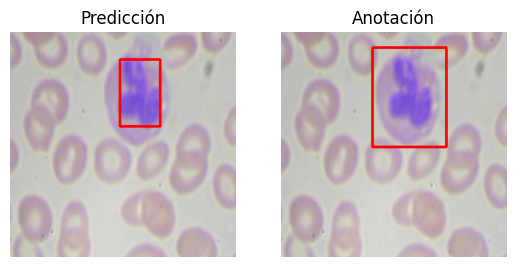

In [16]:
assert type(list_predict) ==list, 'Las detecciones deberian ser una lista de diccionarios'
assert type(list_predict[0])==dict, 'Los elementos de la lista deberian ser diccionarios'
assert len(list_predict)==len(anots['images']), 'Su lista de predicciones debe ser igual a la cantidad de imagenes'

id_image=anots['images'][1]['id']
for i in range(len(list_predict)):
    if list_predict[i]['image_id']==id_image:
        im_name=anots['images'][i]['file_name']
        dict_predict=list_predict[i]

for i in anots['annotations']:
    if i['image_id']==id_image and i['category_id']==3:
        dict_anot=i
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
X,Y,W,H= dict_predict['bbox']

x,y,w,h=dict_anot['bbox']

fig,ax=plt.subplots(1,2)
ax[0].imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
ax[0].axis('off')
ax[0].set_title('Predicción')
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
ax[1].imshow(cv2.rectangle(image,(x,y),(int(x+w),int(y+h)),(255,0,0),3))
ax[1].axis('off')
ax[1].set_title('Anotación')
plt.show()

## Parte 3: Metricas
Ahora que tenemos una lista de predicciones, es momento de calcular la efectividad de nuestro modelo. Continuaremos utilizando como nuestro baseline la umbralización percentile con percentile de 3. Recuerde que las métricas deben calcularse en el fold de validación. Copie las funciones de la Entrega 2 para el cálculo de las curvas de precisión y cobertura junto con el mAP, y calcule estas métricas para el baseline.

In [17]:
list_val_predict= prediccion_total('valid', 'percentile', 3) #Lista de predicciones para el fold valid usando el baseline

In [18]:
def jaccard(A, P):
    """ Esta función devuelve el indice de jaccard para un par anotación-predicción.
    
    Args:
        A (numpy.ndarray): Máscara de anotación.
        P (numpy.ndarray): Máscara de predicción.

    Returns:
        (float): Indice de jaccard calculado
    """
    
    if len(A.shape) != 2:
        A = A[:, :, 0]
    if len(P.shape) != 2:
        P = P[:, :, 0]

    interseccion = np.sum(A * P)
    union = np.sum(A) + np.sum(P) - interseccion
    J = interseccion / union
    return J

def bounding_box(X,Y,W,H):
    """ Esta función crea un arreglo de tamaño 500 X 500 que contiene 1s o píxeles encendidos dadas las coordenadas.

    Args:
        X (float): Coordenada x dentro del arreglo para la esquina superior izquierda.
        Y (float): Coordenada y dentro del arreglo para la esquina superior izquierda.
        W (float): Ancho de la caja.
        H (float): Altura de la caja.

    Returns:
        (numpy.ndarray): arreglo (imagen) con la caja determinada por lo parámetros. 
    
    """
    X, Y, W, H = map(int, [X, Y, W, H])
    A = np.zeros((500, 500), dtype=np.uint8)

    x2 = min(X + W, 500)
    y2 = min(Y + H, 500)
    A[Y:y2, X:x2] = 1

    return A

def verificar_coincidencia(anotacion, prediccion, j_umbral):
    """ Esta función le entra una anotación y una predicción y determina si corresponde a lo mismo o no.

    Args:
        anotacion (dict): diccionario que contiene la información acerca de una anotación.
        prediccion (dict): diccionario que contiene la información acerca de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (bool): True si la anotación y predicción son lo suficientemente similares,
        (float): valor de jaccard calculado mediante la función de jaccard. Recuerde que no es lo mismo que el umbral de jaccard.
    """
    Ax, Ay, Aw, Ah = anotacion["bbox"]
    Px, Py, Pw, Ph = prediccion["bbox"]

    A = bounding_box(Ax, Ay, Aw, Ah)
    P = bounding_box(Px, Py, Pw, Ph)

    interseccion = np.logical_and(A, P).sum()
    union = np.logical_or(A, P).sum()

    jaccard_value = interseccion / union if union > 0 else 0.0
    superposicion = jaccard_value >= j_umbral # Si la predicción y la anotación corresponden a lo mismo.

    return superposicion, jaccard_value

def evaluacion_por_imagen(anotaciones, predicciones, j_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos hay .

    Args:
        anotaciones (list): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    
    if len(anotaciones) == 0 and len(predicciones) == 0:
        return 0, 0, 0
    if len(anotaciones) == 0:
        return 0, len(predicciones), 0
    if len(predicciones) == 0:
        return 0, 0, len(anotaciones)
    
    # 1. Crear matriz de costos (1 - jaccard)
    costos = np.zeros((len(anotaciones), len(predicciones)))
    for i, anot in enumerate(anotaciones):
        for j, pred in enumerate(predicciones):
            _, jaccard_value = verificar_coincidencia(anot, pred, j_umbral=0)  # solo valor
            costos[i, j] = 1 - jaccard_value

    # 2. Resolver el emparejamiento óptimo
    filas, cols = linear_sum_assignment(costos)

    # 3. Contar TP
    TP = 0
    for i, j in zip(filas, cols):
        _, jaccard_value = verificar_coincidencia(anotaciones[i], predicciones[j], j_umbral)
        if jaccard_value >= j_umbral:
            TP += 1

    # 4. Calcular FP y FN
    FP = len(predicciones) - TP
    FN = len(anotaciones) - TP

    return TP, FP, FN

def evaluacion(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos.

    Args:
        anotaciones (dict): diccionario de lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    # 1. Filtrar anotaciones (solo category_id == 3)
    anotaciones_filtradas = [a for a in anotaciones["annotations"] if a["category_id"] == 3]

    # 2. Filtrar predicciones por score >= c_umbral
    predicciones_filtradas = [p for p in predicciones if p["score"] >= c_umbral]

    # 3. Crear diccionario agrupado por image_id
    dataset = {}
    for anot in anotaciones_filtradas:
        img_id = anot["image_id"]
        if img_id not in dataset:
            dataset[img_id] = {"anotaciones": [], "predicciones": []}
        dataset[img_id]["anotaciones"].append(anot)

    for pred in predicciones_filtradas:
        img_id = pred["image_id"]
        if img_id not in dataset:
            dataset[img_id] = {"anotaciones": [], "predicciones": []}
        dataset[img_id]["predicciones"].append(pred)

    # 4. Evaluar imagen por imagen
    TP_total, FP_total, FN_total = 0, 0, 0
    for img_id, datos in dataset.items():
        TP, FP, FN = evaluacion_por_imagen(datos["anotaciones"], datos["predicciones"], j_umbral)
        TP_total += TP
        FP_total += FP
        FN_total += FN

    return TP_total, FP_total, FN_total
    

def Metricas(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función utiliza la función anterior para calcular los TP, FP y FN y luego calcula las métricas

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.

    Returns:
        (float): precision, (float): cobertura, (float): f-medida.
    """
    epsilon = 1e-6
    
    TP, FP, FN = evaluacion(anotaciones, predicciones, j_umbral, c_umbral)
    
    P = TP / (TP + FP + epsilon)
    C = TP / (TP + FN + epsilon)
    F = (2 * P * C) / (P + C + epsilon)
    
    return P, C, F

def Curvas_P_C(anotaciones,predicciones,jaccard):
    """ Esta función calcula la curva de precisión y cobertura utilizando las funciones anteriores.

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        jaccard (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (list): precision, (list): cobertura, (float): f-medida máxima, (float): umbral donde la f-medida es máxima.
    """
    umbrales = np.linspace(0.1, 1.0, 100)
    
    Pr = []
    Co = []
    f_medidas = []
    
    # Calcular métricas para cada umbral
    for c_umbral in umbrales:
        P, C, F1 = Metricas(anotaciones, predicciones, jaccard, c_umbral)
        Pr.append(P)
        Co.append(C)
        f_medidas.append(F1)
    
    # Máximo F-medida
    F = max(f_medidas)
    umbral = umbrales[f_medidas.index(F)]
    
    # Graficar curva P-C
    plt.figure(figsize=(7,5))
    plt.plot(Co, Pr, marker='o', markersize=3, label="Curva Precisión-Cobertura")
    plt.xlabel("Cobertura (Recall)")
    plt.ylabel("Precisión")
    plt.title("Curva Precisión vs Cobertura")
    plt.legend()
    plt.grid(True)
    plt.show()

    return Pr,Co,F,umbral

def mAP(precision,cobertura):
    """ Esta función calcula el mAP para una curva de precisión y cobertura

    Args:
        precision (numpy.ndarray): Arreglo que contiene los valores de precisión para diferentes umbrales.
        cobertura (numpy.ndarray): Arreglo que contiene los valores de cobertura para diferentes umbrales.

    Returns:
        (float): Valor de mAP.
    """
    A=0
    for i in range(len(cobertura)-1):
        A+=(cobertura[i]-cobertura[i+1])*precision[i]
    return A

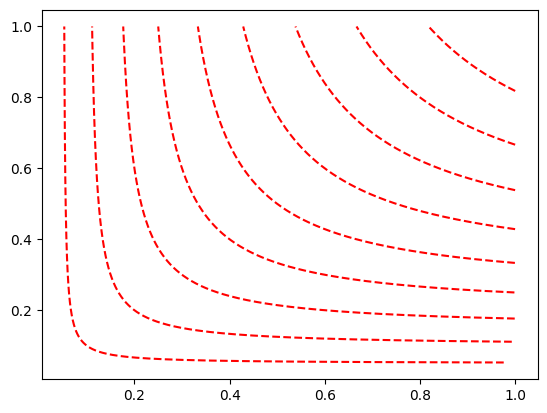

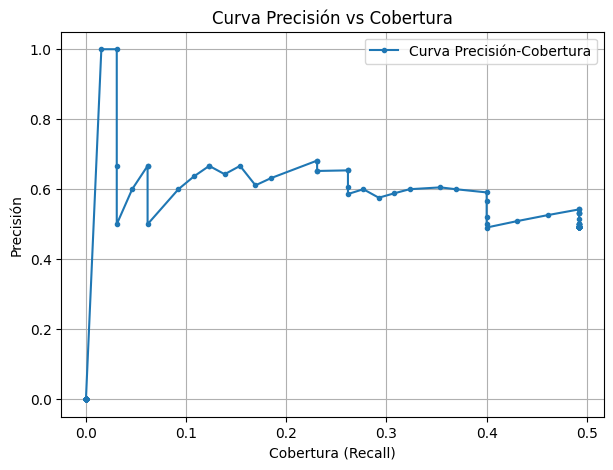

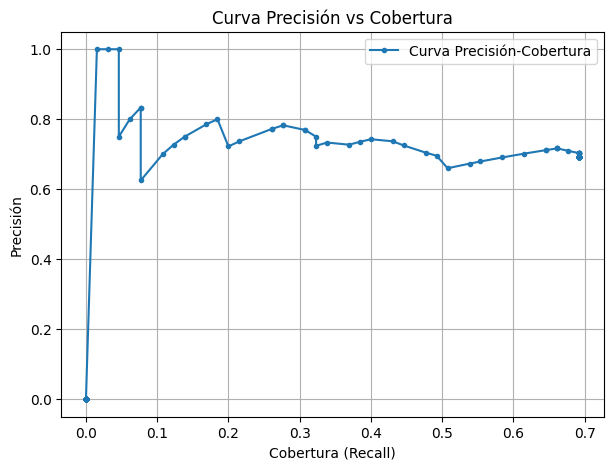

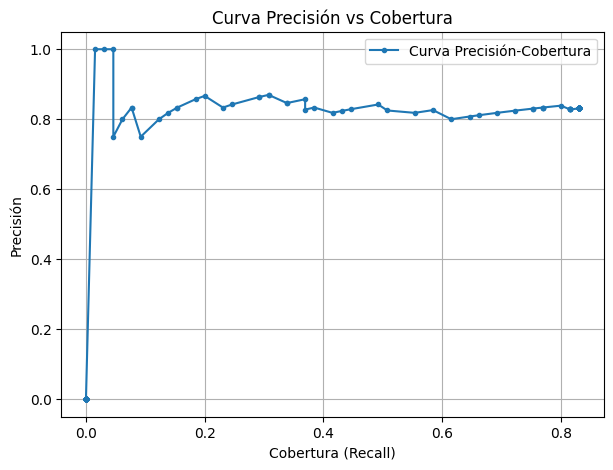

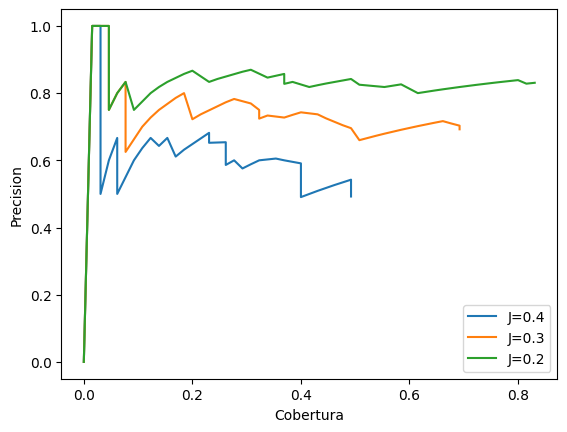

J=0.4, mAP= 0.3105684837121362
J=0.3, mAP= 0.5188265934022147
J=0.2, mAP= 0.6971434584196949


In [19]:
with open(os.path.join('data_mp1','BCCD','valid','_annotations.coco.json'),'rb') as f:
    anots=json.load(f)
    
p=np.arange(0.0001,1.0001,0.0001)
for f in np.arange(0.0,1.2,0.1): #saltos de 0.1 desde una F medida de 0 hasta una F medida de 1
    aux=np.zeros(len(p))
    for i in range(len(p)):
        k=(2*p[i]-f)
        if k>0.001:
            c=f*p[i]/k
            aux[i]=c
    c=np.copy(aux)
    c=c*(c<=1)
    l2=np.where(c!=0)[0]
    C=c[l2]
    P=p[l2]
    plt.plot(C,P,'r--')
Pr1,Co1,F1,umbral1=Curvas_P_C(anots,list_val_predict,0.4)
Pr2,Co2,F2,umbral2=Curvas_P_C(anots,list_val_predict,0.3)
Pr3,Co3,F3,umbral3=Curvas_P_C(anots,list_val_predict,0.2)
plt.plot(Co1,Pr1,label='J=0.4')
plt.plot(Co2,Pr2,label='J=0.3')
plt.plot(Co3,Pr3,label='J=0.2')
plt.xlabel('Cobertura')
plt.ylabel('Precision')
plt.legend()
plt.show()

mAP_04=mAP(Pr1,Co1)
mAP_03=mAP(Pr2,Co2)
mAP_02=mAP(Pr3,Co3)

print(f'J=0.4, mAP= {mAP_04}')
print(f'J=0.3, mAP= {mAP_03}')
print(f'J=0.2, mAP= {mAP_02}')

En esta sección les damos una función que permite la visualización de las anotaciones y predicciones para una imagen particular.

In [20]:
def view_pred(num_im,fold,list_predict):
    """ Esta función visualiza las predicciones y anotaciones para una imagen en un fold.

    Args:
        num_im (int): número que indica la posición de la imagen dentro del fold
        fold (str): indica el fold sobre el que se buscará la imagen. Puede ser "train", "valid" o "test"
        list_predict (list): Lista con las predicciones del fold correspondiente

    Returns:
        (None)
    """
    with open(os.path.join('data_mp1','BCCD',fold,'_annotations.coco.json'),'rb') as f:
        anots=json.load(f)
    id_image=anots['images'][num_im]['id']
    for i in range(len(list_predict)):
        if list_predict[i]['image_id']==id_image:
            im_name=anots['images'][i]['file_name']
            dict_predict=list_predict[i]

    for i in anots['annotations']:
        if i['image_id']==id_image and i['category_id']==3:
            dict_anot=i
    path=os.path.join('.','data_mp1','BCCD',fold,im_name)
    image=io.imread(path)
    X,Y,W,H= dict_predict['bbox']
    x,y,w,h=dict_anot['bbox']
    anotacion=bounding_box(x,y,w,h)
    prediccion=bounding_box(X,Y,W,H)
    Interseccion=np.sum(anotacion*prediccion)
    Union=np.sum(anotacion)+np.sum(prediccion)-Interseccion
    J=Interseccion/Union
    print(J)
    fig,ax=plt.subplots(1,2)
    ax[0].imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
    ax[0].axis('off')
    ax[0].set_title('Predicción')
    path=os.path.join('.','data_mp1','BCCD',fold,im_name)
    image=io.imread(path)
    ax[1].imshow(cv2.rectangle(image,(x,y),(int(x+w),int(y+h)),(255,0,0),3))
    ax[1].axis('off')
    ax[1].set_title('Anotación')
    plt.show()

0.1446217819360362


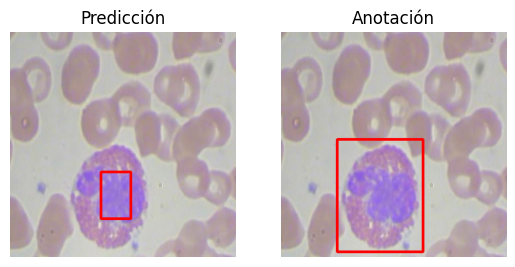

In [21]:
view_pred(1,'valid',list_val_predict)

0.5107198466882261


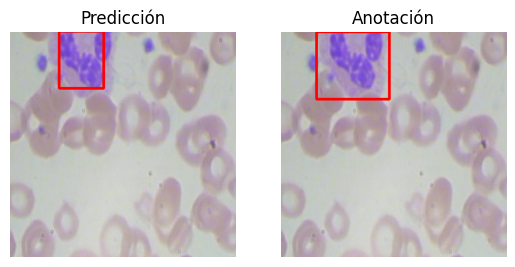

In [22]:
view_pred(4,'valid',list_val_predict)

0.4624795417348609


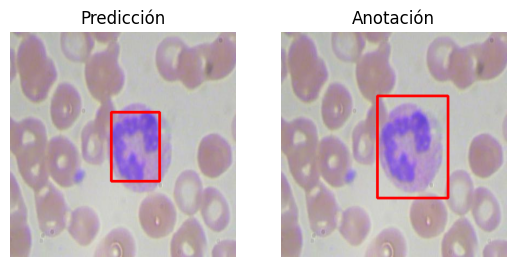

In [23]:
view_pred(31,'valid',list_val_predict)

## Parte 4: Preprocesamiento 

Ahora realizaremos un paso importante para la solución de un problema en la visión por computador, que es el preprocesamiento. Aquí, realizarán transformaciones en los diferentes canales para preparar las imágenes y hacer la segmentación de forma más fácil y precisa. Inicialmente, importaremos una imagen cualquiera y la guardaremos en una variable para usarla más adelante en las pruebas que haremos para cada tipo de preprocesamiento.

In [24]:
img_path = glob.glob(os.path.join('data_mp1/BCCD/train', "BloodImage_00001_jpg*"))[0]
bw_img = io.imread(img_path)[:,:,0] # Variable que contendrá la imagen de un unico canal

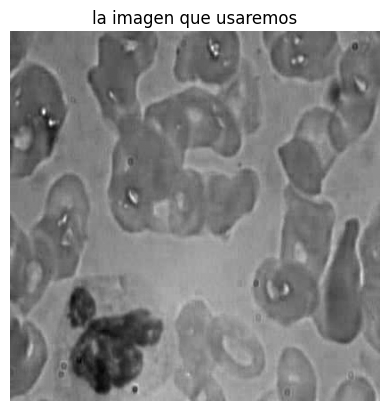

In [25]:
assert len(bw_img.shape)==2,f'La imagen tiene mas dimensiones de las esperadas ({len(bw_img.shape)}). Deberían ser 2'
assert bw_img.shape == (416,416) , f'La imagen tiene un tamaño inesperad0 {(bw_img.shape)}. Debería ser (416,416)'
plt.imshow(bw_img,cmap='gray')
plt.title('la imagen que usaremos')
plt.axis('off')
plt.show()

### 4.1 Transformación gamma
En primer lugar, realizarán un preprocesamiento utilizando la transformación gamma. Para esto, deben realizar la transformación usando cuatro valores diferentes de gamma. Crearemos una función que realice la transformación gamma, recibiendo tanto la imagen como el valor de gamma con el que se realizará la transformación.

**Nota:** La imagen de entrada de la función debe estar en escala de grises. Para asegurarse de que la imagen está en escala de grises, utilice un assert. Si la imagen no está en escala de grises, entonces devuelva un error.

>- Consejo: Recuerde que la transformación gamma inevitablemente realizará un cambio en el rango de intensidades de la imagen, que inicialmente estará entre 0 y 255. Antes de realizar la transformación, cambie el rango de [0,255] a [0,1].

In [26]:
def gamma_trans(image,gamma):
    """ Esta función realiza una transformación gamma a la imagen.

    Args:
        image (numpy.ndarray): Imagen en escala de grises.
        gamma (float): gamma con la cual realizar la transformación gamma a la imagen.

    Returns:
        (numpy.ndarray): Imagen transformada
    """
    assert len(image.shape) == 2, "La imagen debe estar en escala de grises"

    img_norm = image / 255.0
    new_img = np.power(img_norm, gamma)

    return new_img

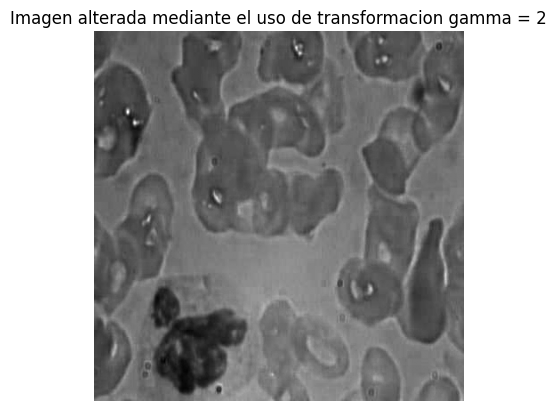

In [27]:
tgamma_img = gamma_trans(bw_img,2)
import numpy as np
assert np.min(tgamma_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tgamma_img)})'
assert np.max(tgamma_img)<=1, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tgamma_img)})'
plt.imshow(tgamma_img,cmap='gray')
plt.title('Imagen alterada mediante el uso de transformacion gamma = 2')
plt.axis('off')
plt.show()

Inicialmente, usarán un valor de gamma mayor a 1 y un valor de gamma menor a 1. Esto con el fin de visualizar cuál de los dos tipos de gamma es el que más nos conviene según el canal que hayamos escogido. Para poder observar las diferencias en el rango y en las intensidades, vamos a graficar tanto la imagen en sí como el histograma de las intensidades. Para ello, realicen un **único subplot** que muestre en cada fila la misma imagen con los diferentes valores de gamma, donde en la primera columna se presente la imagen transformada y en la segunda el histograma de dicha imagen. En la parte 5 ya podrán experimentar con más valores de gamma si lo desean.

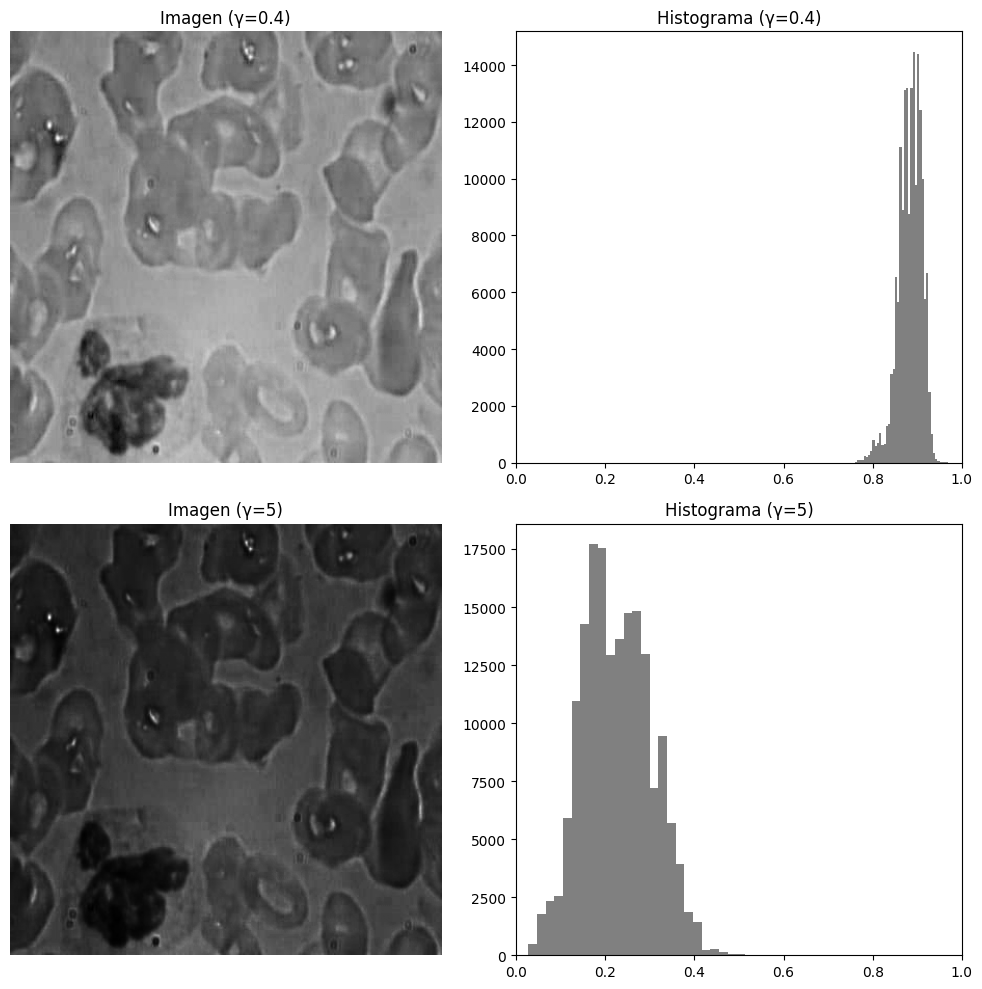

In [28]:
gamma1 = 0.4
gamma2 = 5

g_img1 = gamma_trans(bw_img, gamma1)
g_img2 = gamma_trans(bw_img, gamma2)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# gamma 0.4
axes[0, 0].imshow(g_img1, cmap='gray')
axes[0, 0].set_title(f"Imagen (γ={gamma1})")
axes[0, 0].axis("off")

axes[0, 1].hist(g_img1.ravel(), bins=50, color="gray")
axes[0, 1].set_title(f"Histograma (γ={gamma1})")
axes[0, 1].set_xlim([0, 1])

# gamma 5
axes[1, 0].imshow(g_img2, cmap='gray')
axes[1, 0].set_title(f"Imagen (γ={gamma2})")
axes[1, 0].axis("off")

axes[1, 1].hist(g_img2.ravel(), bins=50, color="gray")
axes[1, 1].set_title(f"Histograma (γ={gamma2})")
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

### 4.2 Ecualización
Otra forma en la que podemos realizar una transformación de intensidad es por medio de la ecualización. En esta, como ya saben, buscaremos distribuir las intensidades de manera que nos acerquemos a un histograma constante. Para ello, utilizaremos la implementación de scikit-image para realizar esta aplicación. Ahora, transformemos la imagen que usamos de ejemplo para este propósito. Utilice 256 bins. En el siguiente [enlace](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist) puede encontrar la documentación de una función para realizar el proceso.

In [29]:
tequ_img = equalize_hist(bw_img, nbins=256) # Variable que contendrá la imagen alterada usando la ecualización


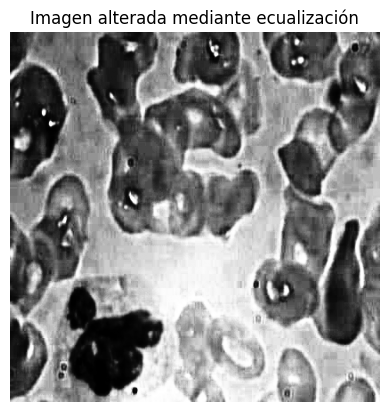

In [30]:
assert np.min(tequ_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tequ_img)})'
assert np.max(tequ_img)<=1, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tequ_img)})'
plt.imshow(tequ_img,cmap='gray')
plt.title('Imagen alterada mediante ecualización')
plt.axis('off')
plt.show()

### 4.3 Especificación
La última manera en la que podemos realizar el preprocesamiento es por medio de la especificación. Aquí, lo más importante será la selección de una imagen objetivo que consideremos adecuada. Esta imagen debe descargarse de internet, es decir, no debe estar en sus archivos locales, ya que no será descargada al momento de verificar. En la siguiente celda, alteren la imagen que tenemos para que coincida con el histograma especificado. En el siguiente [enlace](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.match_histograms) puede encontrar una función para realizar el proceso.

In [31]:
from io import BytesIO

url = requests.get('https://media.sciencephoto.com/image/p2420107/800wm/P2420107-LM_of_human_red_blood_cells_neutrophils.jpg')
img = Image.open(BytesIO(url.content))
img = img.resize((416, 416), Image.LANCZOS)
imagen = np.array(img)
referencia = imagen[:,:,0]


tesp_img = match_histograms(bw_img, referencia, channel_axis=None) # Variable que contendrá la imagen alterada usando la ecualización1

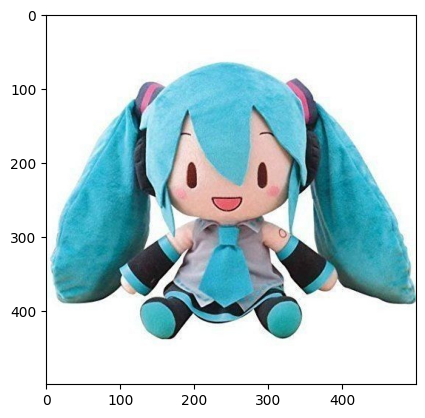

In [32]:
url=requests.get("https://i.pinimg.com/564x/36/6e/dc/366edcfbebd9be15e75c3377cc2da904.jpg",stream=True).raw
imagen=np.array(Image.open(url))
plt.imshow(imagen)

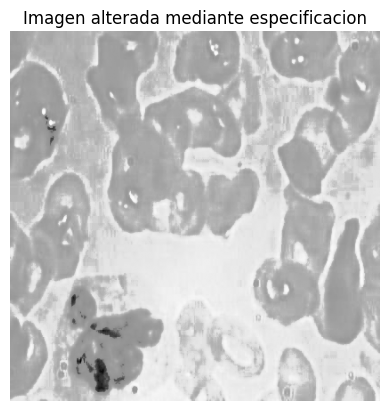

In [33]:
assert np.min(tesp_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tesp_img)})'
assert np.max(tesp_img)<=255, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tesp_img)})'
plt.imshow(tesp_img,cmap='gray')
plt.title('Imagen alterada mediante especificacion')
plt.axis('off')
plt.show()

### 4.4: Preprocesamiento en base de datos

Ahora que sabemos cómo hacer el preprocesamiento, agregaremos esta opción en nuestra función prediccion_total. Añada un parámetro llamado preproc a su función para realizar el preprocesamiento en todas las imágenes de entrada.

In [34]:
def prediccion_total(fold,segmentation_method,preproc=None,gamma=None,image_objetivo=None,dato=None):
    """ Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna un diccionario con la predicción de la anotación.

    Args:
        fold (str): Puede ser "train", "valid" o "test"
        segmentation_method (str): Puede ser "percentile" o "arbitrario"
        preproc (str | None): puede ser "gamma", "ecualizacion" o "especificacion"
        gamma (float | None): valor de gamma para realizar la transformación gamma.
        image_objetivo (str | None): URL de imagen objetivo para realizar la especificación
        dato (float or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parametró será el umbral o el percentil
        
    Returns:
        (list): Lista de diccionarios. Los diccionarios son los generados por la función diccionario_prediccion.
    """

    anotaciones = json.load(open(f'data_mp1/BCCD/{fold}/_annotations.coco.json', 'r'))
    ref = None

    if preproc == "especificacion" and image_objetivo:
        resp = requests.get(image_objetivo).content
        ref_img = Image.open(BytesIO(resp)).convert("L").resize((416,416), Image.LANCZOS)
        ref = np.array(ref_img)

    list_predict = [] #lista de diccionarios de prediccion
    for a in anotaciones["images"]:
        img = io.imread(os.path.join(f"data_mp1/BCCD/{fold}", a["file_name"]))[:, :, 0]

        if preproc == "gamma" and gamma is not None:
            proc_img = (np.power(img/255.0, gamma)*255).astype(np.uint8)
        elif preproc == "ecualizacion":
            proc_img = (equalize_hist(img, nbins=256)*255).astype(np.uint8)
        elif preproc == "especificacion" and ref is not None:
            proc_img = match_histograms(img, ref, channel_axis=None)
        else:
            proc_img = img

        list_predict.append(diccionario_prediccion(proc_img, a["id"], segmentation_method, dato))

    return list_predict

## Parte 5: Experimentos
Por último, debemos experimentar un poco con nuestros parámetros para lograr obtener el mejor modelo posible. Algunos parámetros funcionan bien individualmente y otros en combinación. Realice la experimentación que considere pertinente para obtener el mejor modelo. Experimente principalmente con el preprocesamiento y los métodos de umbralización. En su informe, debe adjuntar una tabla con los resultados de su experimentación, especificando cuál es su baseline y destacando en negrilla su mejor resultado. Realice al menos 5 experimentos.

>- Puede realizar todos los cálculos y gráficos necesarios en el conjunto de entrenamiento, pero las métricas se obtienen en el conjunto de validación.

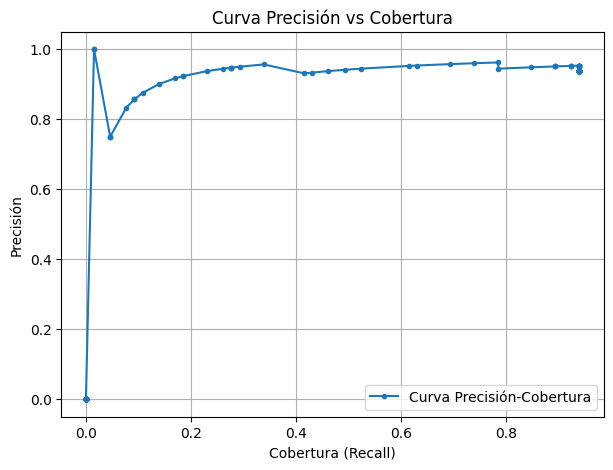

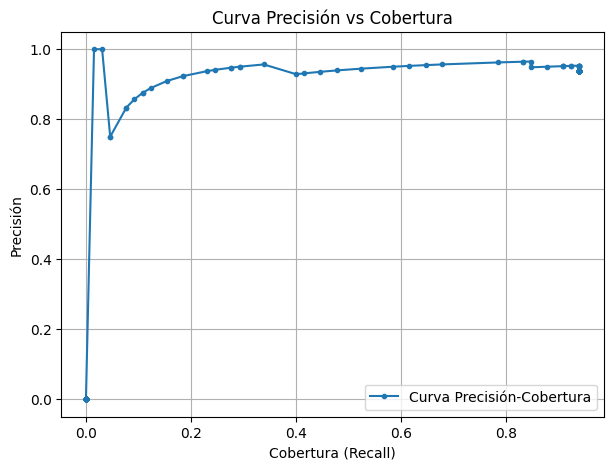

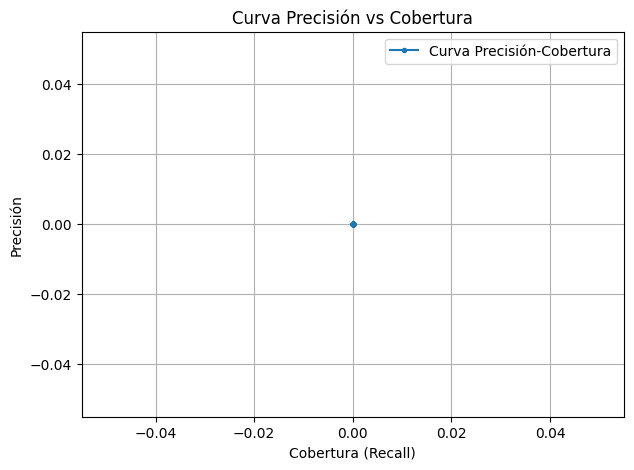

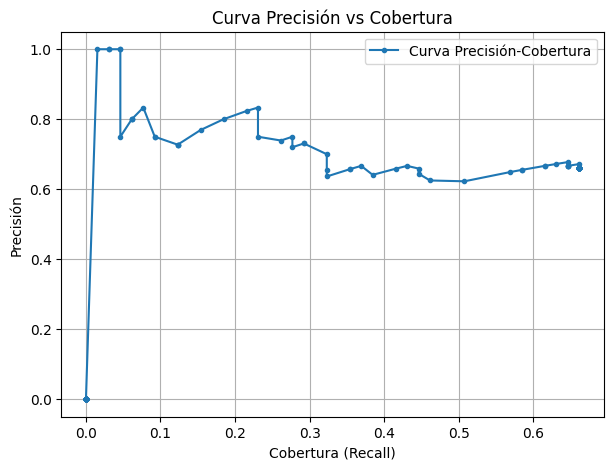

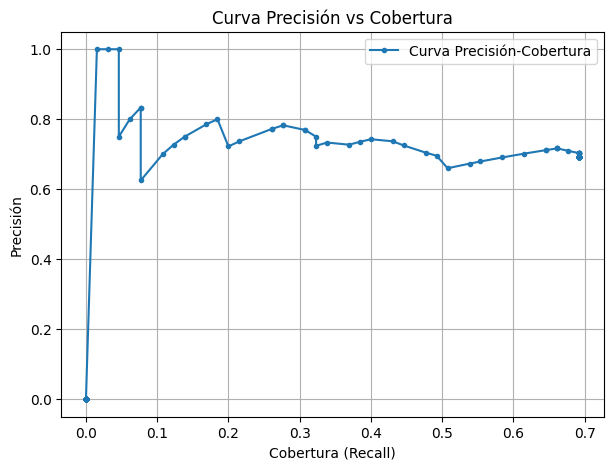

,Experimento,Preproc,Segmentación,Param,J,Precision,Cobertura,F1,mAP,Mejor
0,Baseline,None,Percentile,10,0.3,0.953125,0.938462,0.945736,0.875786,**0.946**
1,Gamma 0.2,Gamma,Percentile,0.2,0.3,0.952381,0.923077,0.945736,0.880426,**0.946**
2,Gamma 4,Gamma,Arbitrario,4,0.3,0.000000,0.000000,0.000000,0.000000,0.0
3,Ecualización,Ecualización,Percentile,-,0.3,0.666667,0.615385,0.666666,0.479691,0.667
4,Especificación,Especificación,Percentile,-,0.3,0.716667,0.661538,0.697674,0.518827,0.698


In [50]:
#ARBITRARIO -> NO ES MUY BUENO

anotaciones_valid = json.load(open('data_mp1/BCCD/valid/_annotations.coco.json', 'r'))

# Lista para guardar resultados de cada experimento
experimentos = []

# 1. Baseline: sin preprocesamiento
pred1 = prediccion_total('valid', 'percentile', preproc=None, dato=10)
Pr1, Co1, F1, umbral1 = Curvas_P_C(anotaciones_valid, pred1, jaccard=0.3)
map1 = mAP(np.array(Pr1), np.array(Co1))
experimentos.append({'Experimento': 'Baseline', 'Preproc': 'None', 'Segmentación': 'Percentile', 'Param': 10, 'J': 0.3,
                     'Precision': Pr1[int(umbral1*99)], 'Cobertura': Co1[int(umbral1*99)], 'F1': F1, 'mAP': map1})

# 2. Gamma = 0.2
pred2 = prediccion_total('valid', 'percentile', preproc='gamma', gamma=0.2, dato=10)
Pr2, Co2, F2, umbral2 = Curvas_P_C(anotaciones_valid, pred2, jaccard=0.3)
map2 = mAP(np.array(Pr2), np.array(Co2))
experimentos.append({'Experimento': 'Gamma 0.2', 'Preproc': 'Gamma', 'Segmentación': 'Percentile', 'Param': 0.2, 'J': 0.3,
                     'Precision': Pr2[int(umbral2*99)], 'Cobertura': Co2[int(umbral2*99)], 'F1': F2, 'mAP': map2})

# 3. Gamma = 4
pred3 = prediccion_total('valid', 'arbitrario', preproc='gamma', gamma=4, dato=100)
Pr3, Co3, F3, umbral3 = Curvas_P_C(anotaciones_valid, pred3, jaccard=0.3)
map3 = mAP(np.array(Pr3), np.array(Co3))
experimentos.append({'Experimento': 'Gamma 4', 'Preproc': 'Gamma', 'Segmentación': 'Arbitrario', 'Param': 4, 'J': 0.3,
                     'Precision': Pr3[int(umbral3*99)], 'Cobertura': Co3[int(umbral3*99)], 'F1': F3, 'mAP': map3})

# 4. Ecualización
pred4 = prediccion_total('valid', 'percentile', preproc='ecualizacion', dato=3)
Pr4, Co4, F4, umbral4 = Curvas_P_C(anotaciones_valid, pred4, jaccard=0.3)
map4 = mAP(np.array(Pr4), np.array(Co4))
experimentos.append({'Experimento': 'Ecualización', 'Preproc': 'Ecualización', 'Segmentación': 'Percentile', 'Param': '-', 'J': 0.3,
                     'Precision': Pr4[int(umbral4*99)], 'Cobertura': Co4[int(umbral4*99)], 'F1': F4, 'mAP': map4})

# 5. Especificación
url_ref = 'https://media.sciencephoto.com/image/p2420107/800wm/P2420107-LM_of_human_red_blood_cells_neutrophils.jpg'
pred5 = prediccion_total('valid', 'percentile', preproc='especificacion', image_objetivo=url_ref, dato=3)
Pr5, Co5, F5, umbral5 = Curvas_P_C(anotaciones_valid, pred5, jaccard=0.3)
map5 = mAP(np.array(Pr5), np.array(Co5))
experimentos.append({'Experimento': 'Especificación', 'Preproc': 'Especificación', 'Segmentación': 'Percentile', 'Param': '-', 'J': 0.3,
                     'Precision': Pr5[int(umbral5*99)], 'Cobertura': Co5[int(umbral5*99)], 'F1': F5, 'mAP': map5})


df_exp = pd.DataFrame(experimentos)
mejor_F1 = df_exp['F1'].max()
df_exp['Mejor'] = df_exp['F1'].apply(lambda x: '**' + str(round(x,3)) + '**' if x==mejor_F1 else round(x,3))

# Mostrar resultados
df_exp[['Experimento','Preproc','Segmentación','Param','J','Precision','Cobertura','F1','mAP','Mejor']]

## Parte 6: Prueba
Ya hemos determinado cuáles parámetros son los mejores para nuestro modelo. Ahora, realice las predicciones en el conjunto de prueba para determinar la potencial eficacia de su modelo en la vida real. Adjunte estos resultados en su informe. Adicionalmente, incluya al menos 4 detecciones de su modelo; puede usar la función view_pred que se le proporcionó anteriormente, aprenda a utilizarla. Se usará un umbral de 0.6 de Jaccard para la evaluación.

>- Parte de su calificación será superar el baseline; si no lo logra, su código tendrá una calificación máxima de 2/2.5. Si logra superarlo, tendrá una calificación de 3/2.5 (tendrá un bono de 0.5).

Resultados en test con Jaccard 0.6:
Precisión: 0.448
Cobertura: 0.406
F1: 0.426
0.336601433830653


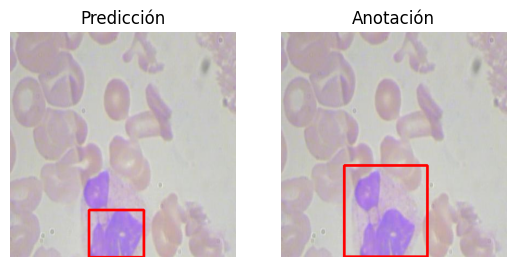

0.6729398346164813


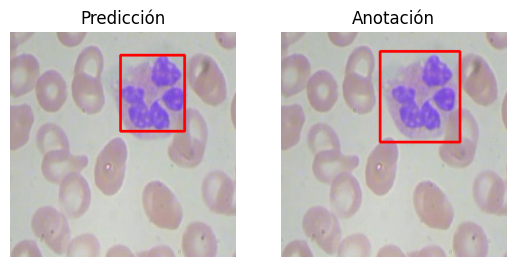

0.4849977608598298


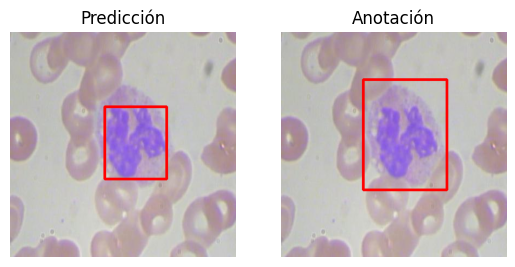

0.663646017699115


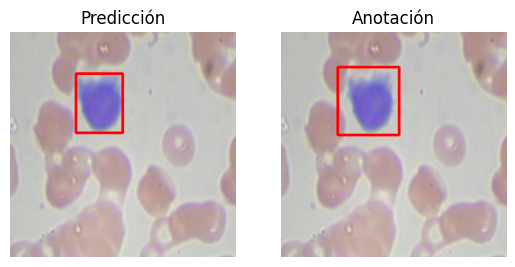

In [39]:
# Usen esta celda para importar funciones necesarias

# Parámetros del mejor experimento (ajustar según la Parte 5)
mejor_preproc = 'gamma'   # 'gamma', 'ecualizacion', 'especificacion' o None
mejor_param = 0.2         # valor de gamma, percentil o umbral según preprocesamiento
mejor_segment = 'percentile'
dato_segment = 10          # percentil u umbral arbitrario según segmentación

list_test_predict = prediccion_total(
    fold='test',
    segmentation_method=mejor_segment,
    preproc=mejor_preproc,
    gamma=mejor_param if mejor_preproc=='gamma' else None,
    image_objetivo=None,  # si usaras 'especificacion', poner URL aquí
    dato=dato_segment
)


anotaciones_test = json.load(open('data_mp1/BCCD/test/_annotations.coco.json', 'r'))
P_test, C_test, F_test = Metricas(anotaciones_test, list_test_predict, j_umbral=0.6, c_umbral=0.5)

print(f"Resultados en test con Jaccard 0.6:")
print(f"Precisión: {P_test:.3f}")
print(f"Cobertura: {C_test:.3f}")
print(f"F1: {F_test:.3f}")

view_pred(1, 'test', list_test_predict)
view_pred(5, 'test', list_test_predict)
view_pred(10, 'test', list_test_predict)
view_pred(15, 'test', list_test_predict)

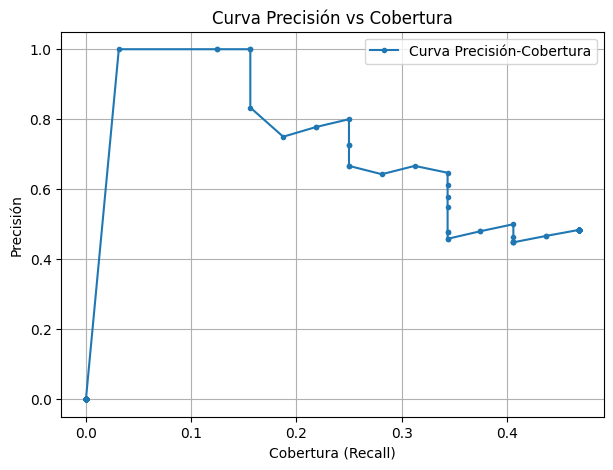

In [40]:
with open(os.path.join('data_mp1','BCCD','test','_annotations.coco.json'),'rb') as f:
    anots=json.load(f)
    
Pr1,Co1,F1,umbral1=Curvas_P_C(anots,list_test_predict,0.6)
mAP_04=mAP(Pr1,Co1)

In [41]:
print(mAP_04)

0.35046547770579617


In [42]:
assert mAP_04>0.2, 'Su metodo no es mejor que el baseline'

## Entregables
Los entregables para esta primera entrega son los siguientes:

- Jupyter notebook (.ipynb): El notebook debe estar completamente resuelto. Recuerden que la nota depende del correcto funcionamiento de su código.

- Archivo de texto (.txt): Un archivo de texto con las secciones de código del Jupyter notebook. Para más información sobre cómo convertir las secciones de código de su Jupyter notebook a un archivo de texto, pueden ver el video disponible en el siguiente [enlace](https://uniandes-edu-co.zoom.us/rec/share/QOxUUIw7Uz9DsnKPyftOXZgM4bx5d7KHMYK-dqvGnkyJ2GfqvT7NU3lhQc0NtNSU.jveWB2H34S4uLIoB).

- Informe (.pdf): El informe constará de responder las preguntas, además, asegúrese de incluir los elementos adicionales, como subplots, gráficos, tablas o cualquiera elemento adicional que se mencione. Toda la información sobre preguntas y elementos adicionales está en la siguiente sección de informe. El informe debe utilizar el formato que puede encontrar siguiente [enlace](https://github.com/cvpr-org/author-kit). Si tiene dudas de cómo utilizar el formato puede preguntar al Asistente Graduado.

# Informe

La extensión máxima es de 5 páginas sin incluir anexos ni referencias. Las preguntas a responder en su informe son las siguientes.

### Parte 1: Umbralización
- Mencione las ventajas y desventajas de cada uno de los métodos de umbralización.
- Mencione las ventajas y desventajas del método de umbralización otsu. ¿En este caso sería útil?

### Parte 2: Predicciones
- ¿Qué desafíos pueden surgir al utilizar el porcentaje de área positiva dentro del bbox como score? ¿Qué otra idea podría ser valida?

### Parte 3: Procesamiento de la base de datos
- ¿Exactamente cuál es el formato de las predicciones? Describa explícitamente qué información contiene el diccionario de predicciones.

### Parte 4: Preprocesamiento
- Muestre y describa los resultados cualitativos (imágenes e histogramas) de su experimentación con el valor de gamma en la transformación. ¿Cuáles resultados fueron mejores? Justifique.
- Muestre y describa los resultados luego de usar la ecualización y especificación por separado ¿Los resultados fueron mejores que la imagen original? ¿Por qué?

### Parte 5: Experimentación
- Adjunte y describa la tabla con los resultados del mAP de los experimentos. Analice todos sus experimento, destacando porque cada experimento tuvo esos resultados.
- ¿El pre-procesamiento siempre fue útil en sus experimentos, es decir, quitar el preprocesamiento no generaría cambios?

### Parte 6: Prueba
- Incluya y describa los resultados, incluyendo el subplot, la gráfica de la curva P-C, y el mAP.
- ¿Son congruentes sus resultados en la prueba con los obtenidos en la validación?
- ¿Qué problemas pueden observar en sus resultados cualitativos?
- ¿Cómo mejorarían su método?

In [51]:
from utils import *
converter('main_Nocua_Muriel_Castillo')